In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Model parameters
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 50
batch_size = 32

# Define the dataset path and categories
dataset_path = '/content/drive/My Drive/new_fol_vig'
categories = ['NE', 'DME', 'DR1', 'GL']

# Initialize an empty list to store labels
labels = []

# Iterate through the directories in the dataset path
for category in categories:
    category_path = os.path.join(dataset_path, category)
    # Check if the directory exists and is indeed a directory
    if os.path.isdir(category_path):
        # List all files in the category directory
        file_names = os.listdir(category_path)
        # Iterate through each file in the directory
        for file_name in file_names:
            # Construct the full file path
            file_path = os.path.join(category_path, file_name)
            # Append the filename and category to the labels list
            labels.append((file_path, category))

# Create a DataFrame from the labels list
df = pd.DataFrame(data=labels, columns=['filename', 'category'])

# Encode the 'category' column
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
print(df.head())
df = df.sample(frac=1).reset_index(drop=True)

# Split the DataFrame into train and validation sets
train_df, validate_df = train_test_split(df, test_size=0.2)

# Load images and labels from DataFrame
X_train = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in train_df['filename']])
y_train = np.array(train_df['category'])
X_validate = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in validate_df['filename']])
y_validate = np.array(validate_df['category'])

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_validate = X_validate / 255.0



Mounted at /content/drive
                                            filename  category
0  /content/drive/My Drive/new_fol_vig/NE/NL_001.png         3
1  /content/drive/My Drive/new_fol_vig/NE/NL_004.png         3
2  /content/drive/My Drive/new_fol_vig/NE/NL_005.png         3
3  /content/drive/My Drive/new_fol_vig/NE/NL_006.png         3
4  /content/drive/My Drive/new_fol_vig/NE/NL_002.png         3


In [ ]:
# Define the model
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)

x = BatchNormalization(axis=1)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(categories), activation='softmax')(x)  # Change activation to softmax and number of neurons to num_classes #, kernel_constraint=unit_norm(
model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',  # Change loss function to sparse categorical cross-entropy
              optimizer=optimizers.Adam(lr=3e-4),  # Change optimizer to Adam and learning rate to 3e-4
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size) #, callbacks=[early_stopping]



58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/50
11/11 [==============================] - 24s 968ms/step - loss: 0.7305 - accuracy: 0.7061 - val_loss: 30.2623 - val_accuracy: 0.2651
Epoch 2/50
11/11 [==============================] - 2s 193ms/step - loss: 0.3928 - accuracy: 0.8061 - val_loss: 65.8013 - val_accuracy: 0.2651
Epoch 3/50
11/11 [==============================] - 2s 190ms/step - loss: 0.3275 - accuracy: 0.8364 - val_loss: 52.0151 - val_accuracy: 0.2651
Epoch 4/50
11/11 [==============================] - 2s 166ms/step - loss: 0.2871 - accuracy: 0.8667 - val_loss: 46.0478 - val_accuracy: 0.2651
Epoch 5/50
11/11 [==============================] - 2s 191ms/step - loss: 0.2624 - accuracy: 0.9061 - val_loss: 30.9302 - val_accuracy: 0.2651
Epoch 6/50
11/11 [==============================] - 2s 162ms/step - loss: 0.2178 - accuracy: 0.8939 - val_loss: 23.7828 - val_accuracy: 0.2651
Epoch 7/50
11/11 [==============================] - 2s 191ms/step - loss: 0.1915 - accuracy: 0.9152 - val_loss: 9.1889 - val_accuracy: 0.5181

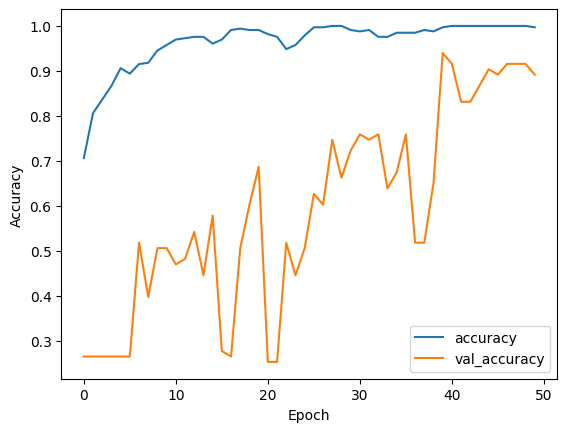

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

3/3 [==============================] - 0s 117ms/step
Classification Report:
              precision    recall  f1-score   support

          NE       0.76      1.00      0.86        22
         DME       1.00      1.00      1.00        21
         DR1       0.89      0.80      0.84        20
          GL       1.00      0.75      0.86        20

    accuracy                           0.89        83
   macro avg       0.91      0.89      0.89        83
weighted avg       0.91      0.89      0.89        83



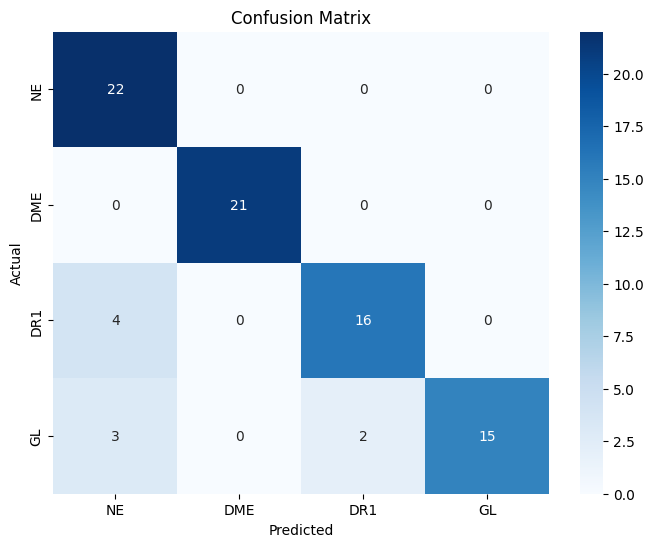

In [ ]:
y_pred = model.predict(X_validate)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_validate, y_pred_classes, target_names=categories))

# Generate confusion matrix
cm = confusion_matrix(y_validate, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

drive.mount('/content/drive')

# Model parameters
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 50
batch_size = 32

# Define the dataset path and categories
dataset_path = '/content/drive/My Drive/new_fol_vig'
categories = ['NE', 'DME']

# Initialize an empty list to store labels
labels = []

# Iterate through the directories in the dataset path
for category in categories:
    category_path = os.path.join(dataset_path, category)
    # Check if the directory exists and is indeed a directory
    if os.path.isdir(category_path):
        # List all files in the category directory
        file_names = os.listdir(category_path)
        # Iterate through each file in the directory
        for file_name in file_names:
            # Construct the full file path
            file_path = os.path.join(category_path, file_name)
            # Append the filename and category to the labels list
            labels.append((file_path, category))

# Create a DataFrame from the labels list
df = pd.DataFrame(data=labels, columns=['filename', 'category'])

# Encode the 'category' column
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
print(df.head())
df = df.sample(frac=1).reset_index(drop=True)

# Split the DataFrame into train and validation sets
train_df, validate_df = train_test_split(df, test_size=0.2)

# Load images and labels from DataFrame
X_train = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in train_df['filename']])
y_train = np.array(train_df['category'])
X_validate = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in validate_df['filename']])
y_validate = np.array(validate_df['category'])

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_validate = X_validate / 255.0




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                            filename  category
0  /content/drive/My Drive/new_fol_vig/NE/NL_001.png         1
1  /content/drive/My Drive/new_fol_vig/NE/NL_004.png         1
2  /content/drive/My Drive/new_fol_vig/NE/NL_005.png         1
3  /content/drive/My Drive/new_fol_vig/NE/NL_006.png         1
4  /content/drive/My Drive/new_fol_vig/NE/NL_002.png         1


NameError: name 'GlobalAveragePooling2D' is not defined

Epoch 1/50
5/5 [==============================] - 11s 2s/step - loss: 0.4014 - accuracy: 0.8188 - val_loss: 0.8118 - val_accuracy: 0.7105
Epoch 2/50
5/5 [==============================] - 1s 214ms/step - loss: 0.0395 - accuracy: 0.9933 - val_loss: 28.3287 - val_accuracy: 0.5263
Epoch 3/50
5/5 [==============================] - 1s 215ms/step - loss: 0.0152 - accuracy: 0.9933 - val_loss: 32.7659 - val_accuracy: 0.5263
Epoch 4/50
5/5 [==============================] - 1s 215ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 24.9893 - val_accuracy: 0.5263
Epoch 5/50
5/5 [==============================] - 1s 215ms/step - loss: 0.0117 - accuracy: 0.9933 - val_loss: 14.3130 - val_accuracy: 0.5263
Epoch 6/50
5/5 [==============================] - 1s 227ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.1443 - val_accuracy: 0.9211
Epoch 7/50
5/5 [==============================] - 1s 224ms/step - loss: 8.0252e-04 - accuracy: 1.0000 - val_loss: 9.5116e-05 - val_accuracy: 1.0000
Epoch 8/50

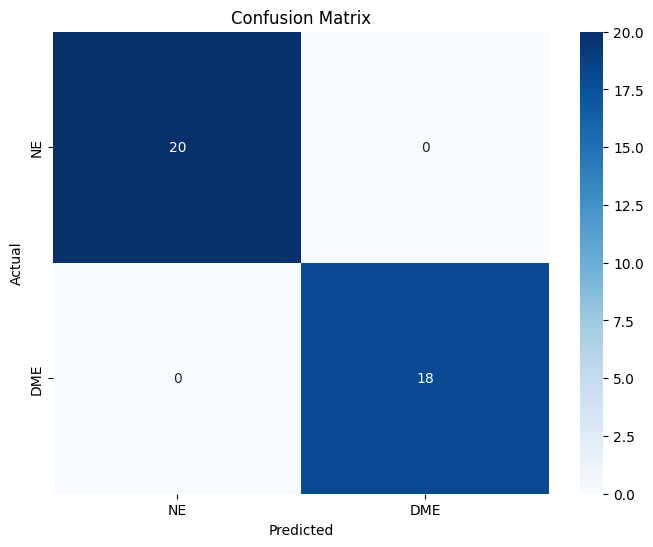

In [ ]:
# Define the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)

x = BatchNormalization(axis=1)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(categories), activation='softmax')(x)  # Change activation to softmax and number of neurons to num_classes #, kernel_constraint=unit_norm(
model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',  # Change loss function to sparse categorical cross-entropy
              optimizer=optimizers.Adam(lr=3e-4),  # Change optimizer to Adam and learning rate to 3e-4
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])


# Make predictions
y_pred = np.argmax(model.predict(X_validate), axis=-1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_validate, y_pred, target_names=categories))

# Generate confusion matrix
cm = confusion_matrix(y_validate, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

drive.mount('/content/drive')

# Model parameters
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 50
batch_size = 32

# Define the dataset path and categories
dataset_path = '/content/drive/My Drive/new_fol_vig'
categories = ['NE', 'DR1']

# Initialize an empty list to store labels
labels = []

# Iterate through the directories in the dataset path
for category in categories:
    category_path = os.path.join(dataset_path, category)
    # Check if the directory exists and is indeed a directory
    if os.path.isdir(category_path):
        # List all files in the category directory
        file_names = os.listdir(category_path)
        # Iterate through each file in the directory
        for file_name in file_names:
            # Construct the full file path
            file_path = os.path.join(category_path, file_name)
            # Append the filename and category to the labels list
            labels.append((file_path, category))

# Create a DataFrame from the labels list
df = pd.DataFrame(data=labels, columns=['filename', 'category'])

# Encode the 'category' column
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
print(df.head())
df = df.sample(frac=1).reset_index(drop=True)

# Split the DataFrame into train and validation sets
train_df, validate_df = train_test_split(df, test_size=0.2)

# Load images and labels from DataFrame
X_train = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in train_df['filename']])
y_train = np.array(train_df['category'])
X_validate = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in validate_df['filename']])
y_validate = np.array(validate_df['category'])

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_validate = X_validate / 255.0




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                            filename  category
0  /content/drive/My Drive/new_fol_vig/NE/NL_001.png         1
1  /content/drive/My Drive/new_fol_vig/NE/NL_004.png         1
2  /content/drive/My Drive/new_fol_vig/NE/NL_005.png         1
3  /content/drive/My Drive/new_fol_vig/NE/NL_006.png         1
4  /content/drive/My Drive/new_fol_vig/NE/NL_002.png         1


Epoch 1/50
6/6 [==============================] - 13s 2s/step - loss: 0.2151 - accuracy: 0.9023 - val_loss: 2.1698 - val_accuracy: 0.4545
Epoch 2/50
6/6 [==============================] - 1s 167ms/step - loss: 9.8885e-05 - accuracy: 1.0000 - val_loss: 7.0656 - val_accuracy: 0.4545
Epoch 3/50
6/6 [==============================] - 1s 205ms/step - loss: 1.0018e-05 - accuracy: 1.0000 - val_loss: 1.5042 - val_accuracy: 0.6364
Epoch 4/50
6/6 [==============================] - 1s 172ms/step - loss: 8.0503e-04 - accuracy: 1.0000 - val_loss: 6.4524 - val_accuracy: 0.4545
Epoch 5/50
6/6 [==============================] - 1s 172ms/step - loss: 1.8079e-05 - accuracy: 1.0000 - val_loss: 40.8773 - val_accuracy: 0.4545
Epoch 6/50
6/6 [==============================] - 1s 197ms/step - loss: 3.6550e-04 - accuracy: 1.0000 - val_loss: 24.5207 - val_accuracy: 0.4545
Epoch 7/50
6/6 [==============================] - 1s 175ms/step - loss: 3.5981e-05 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.9

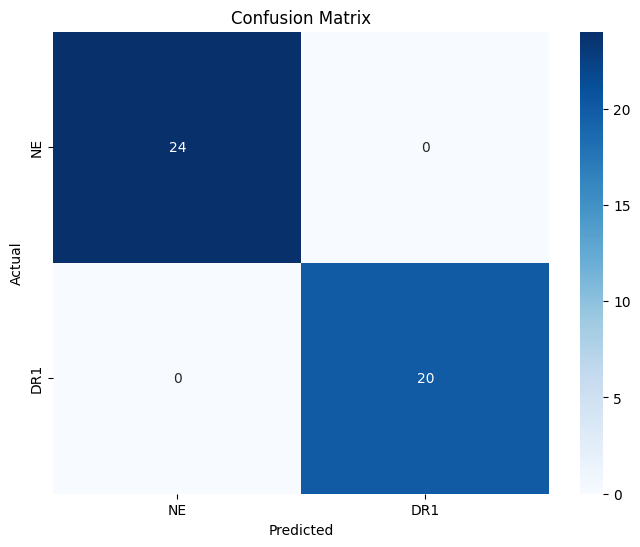

In [ ]:
# Define the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)

x = BatchNormalization(axis=1)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(categories), activation='softmax')(x)  # Change activation to softmax and number of neurons to num_classes #, kernel_constraint=unit_norm(
model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',  # Change loss function to sparse categorical cross-entropy
              optimizer=optimizers.Adam(lr=3e-4),  # Change optimizer to Adam and learning rate to 3e-4
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])


# Make predictions
y_pred = np.argmax(model.predict(X_validate), axis=-1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_validate, y_pred, target_names=categories))

# Generate confusion matrix
cm = confusion_matrix(y_validate, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

drive.mount('/content/drive')

# Model parameters
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 50
batch_size = 32

# Define the dataset path and categories
dataset_path = '/content/drive/My Drive/new_fol_vig'
categories = ['NE', 'GL']

# Initialize an empty list to store labels
labels = []

# Iterate through the directories in the dataset path
for category in categories:
    category_path = os.path.join(dataset_path, category)
    # Check if the directory exists and is indeed a directory
    if os.path.isdir(category_path):
        # List all files in the category directory
        file_names = os.listdir(category_path)
        # Iterate through each file in the directory
        for file_name in file_names:
            # Construct the full file path
            file_path = os.path.join(category_path, file_name)
            # Append the filename and category to the labels list
            labels.append((file_path, category))

# Create a DataFrame from the labels list
df = pd.DataFrame(data=labels, columns=['filename', 'category'])

# Encode the 'category' column
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
print(df.head())
df = df.sample(frac=1).reset_index(drop=True)

# Split the DataFrame into train and validation sets
train_df, validate_df = train_test_split(df, test_size=0.2)

# Load images and labels from DataFrame
X_train = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in train_df['filename']])
y_train = np.array(train_df['category'])
X_validate = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in validate_df['filename']])
y_validate = np.array(validate_df['category'])

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_validate = X_validate / 255.0




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                            filename  category
0  /content/drive/My Drive/new_fol_vig/NE/NL_001.png         1
1  /content/drive/My Drive/new_fol_vig/NE/NL_004.png         1
2  /content/drive/My Drive/new_fol_vig/NE/NL_005.png         1
3  /content/drive/My Drive/new_fol_vig/NE/NL_006.png         1
4  /content/drive/My Drive/new_fol_vig/NE/NL_002.png         1


Epoch 1/50
5/5 [==============================] - 12s 2s/step - loss: 1.0747 - accuracy: 0.5613 - val_loss: 0.9561 - val_accuracy: 0.6410
Epoch 2/50
5/5 [==============================] - 1s 222ms/step - loss: 0.6380 - accuracy: 0.6710 - val_loss: 5.1120 - val_accuracy: 0.6154
Epoch 3/50
5/5 [==============================] - 1s 189ms/step - loss: 0.4698 - accuracy: 0.7871 - val_loss: 11.1879 - val_accuracy: 0.6154
Epoch 4/50
5/5 [==============================] - 1s 226ms/step - loss: 0.4918 - accuracy: 0.7677 - val_loss: 1.0299 - val_accuracy: 0.7692
Epoch 5/50
5/5 [==============================] - 1s 231ms/step - loss: 0.3393 - accuracy: 0.8710 - val_loss: 24.9523 - val_accuracy: 0.6154
Epoch 6/50
2/2 [==============================] - 0s 112ms/step
Classification Report:
              precision    recall  f1-score   support

          NE       0.64      0.96      0.77        24
          GL       0.67      0.13      0.22        15

    accuracy                           0.64      

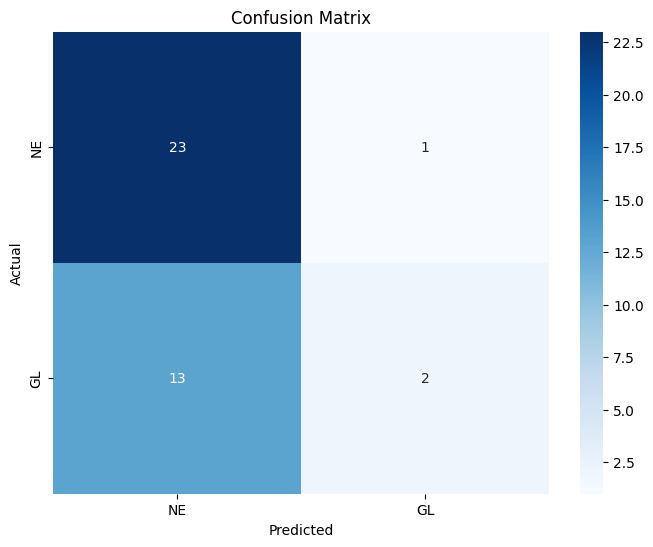

In [ ]:
# Define the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)

x = BatchNormalization(axis=1)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(categories), activation='softmax')(x)  # Change activation to softmax and number of neurons to num_classes #, kernel_constraint=unit_norm(
model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',  # Change loss function to sparse categorical cross-entropy
              optimizer=optimizers.Adam(lr=3e-4),  # Change optimizer to Adam and learning rate to 3e-4
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])


# Make predictions
y_pred = np.argmax(model.predict(X_validate), axis=-1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_validate, y_pred, target_names=categories))

# Generate confusion matrix
cm = confusion_matrix(y_validate, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()